In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input/flowers/he_challenge_data/data"))

['train', 'test', 'train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
import fastai
from fastai.vision import *
path=Path('../input/flowers/he_challenge_data/data')
df=pd.read_csv(path/'train.csv')

In [3]:
def get_label(fname):
    fname=str(fname)
    fname=fname.replace('../input/flowers/he_challenge_data/data/train/','')
    fname=fname.replace('.jpg','')
    return df.iloc[int(fname)].category

In [4]:
np.random.seed(42)
data=(ImageList.from_folder(path/'train')
                  .split_by_rand_pct(0.2)
                  .label_from_func(get_label)
                .transform(tfms=get_transforms(),size=128)
                .add_test((path/'test').ls(), label=None)
                .databunch(path=Path('.'), bs=32)
                .normalize(imagenet_stats))

In [5]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 30098553.01it/s]


In [6]:
#learn.lr_find()
#learn.recorder.plot()

In [7]:
#Got it from stage-1.pth

#learn.fit_one_cycle(3,slice(2*1e-03,2*1e-02))
#learn.save('stage-1')


In [8]:
!mkdir models

In [9]:
!cp '../input/flores/stage-1.pth' 'models/stage-1.pth'
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (14832 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
89,83,51,41,82
Path: ../input/flowers/he_challenge_data/data/train;

Valid: LabelList (3708 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
56,2,46,51,29
Path: ../input/flowers/he_challenge_data/data/train;

Test: LabelList (2009 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: ../input/flowers/he_challenge_data/data/train, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilati

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


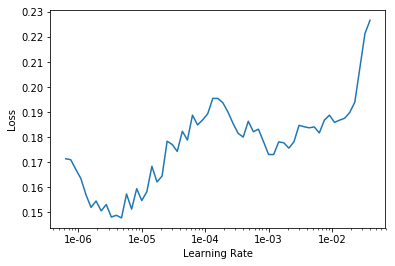

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(1,slice(2*1e-04,2*1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.157941,0.064043,0.019687,03:06


In [12]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


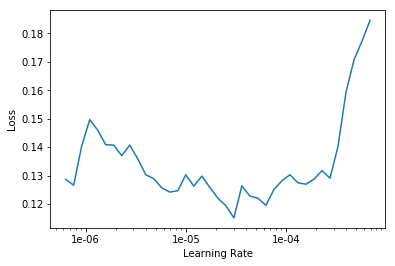

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(2,1e-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.123914,0.052059,0.014833,03:01
1,0.124548,0.042264,0.011057,03:06


In [15]:
learn.save('stage-2')

In [16]:
data=(ImageList.from_folder(path/'train')
                .split_by_rand_pct(0.2)
                .label_from_func(get_label)
                .transform(tfms=get_transforms(),size=256)
                .add_test((path/'test').ls(), label=None)
                .databunch(path=Path('.'), bs=32)
                .normalize(imagenet_stats))
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


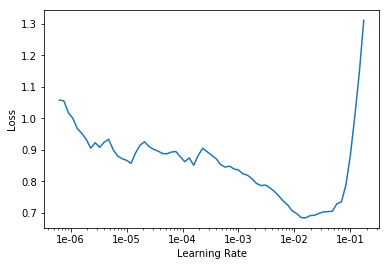

In [17]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(3,slice(1e-03,5*1e-02))
learn.save('stage-1-256')

epoch,train_loss,valid_loss,error_rate,time
0,3.456330,2.761465,0.219795,03:31
1,1.139699,49.321793,0.066343,03:34
2,0.312963,30.582741,0.032632,03:30


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


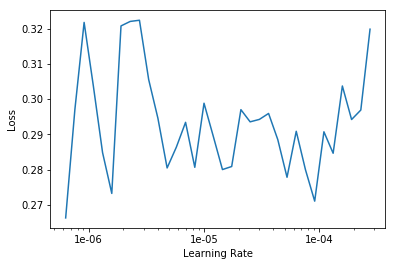

In [19]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1,slice(2*1e-04,2*1e-03))

epoch,train_loss,valid_loss,error_rate,time
0,0.684467,1.063110,0.057174,03:39


In [21]:
learn.save('stage-2-256')

In [22]:
data=(ImageList.from_folder(path/'train')
                .split_by_rand_pct(0.2)
                .label_from_func(get_label)
                .transform(tfms=get_transforms())
                .add_test((path/'test').ls(), label=None)
                .databunch(path=Path('.'), bs=32)
                .normalize(imagenet_stats))
learn.data=data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


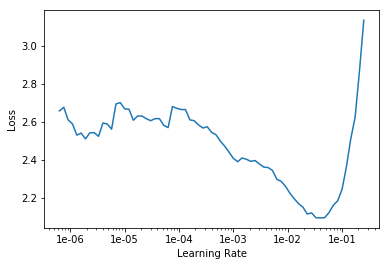

In [23]:
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2,slice(2*1e-04,2*1e-02))
learn.save('stage-1-512')

epoch,train_loss,valid_loss,error_rate,time
0,0.776535,5.029431,0.100054,08:17
1,0.257307,10.770852,0.048004,08:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


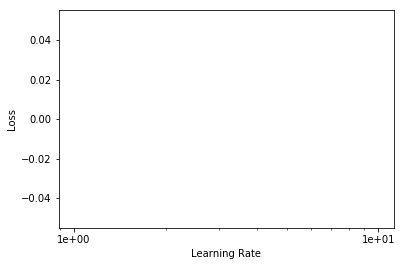

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(2,2*1e-04)
learn.save('stage-1-512-1')

epoch,train_loss,valid_loss,error_rate,time
0,0.217430,9.689570,0.038296,07:58
1,0.224035,5.142993,0.042880,08:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


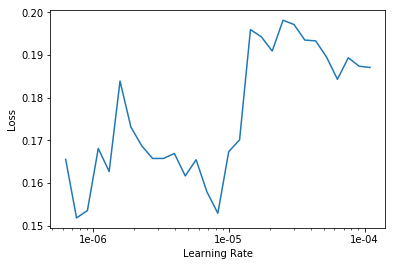

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(1,1e-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.198791,4.333599,0.030744,12:32


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


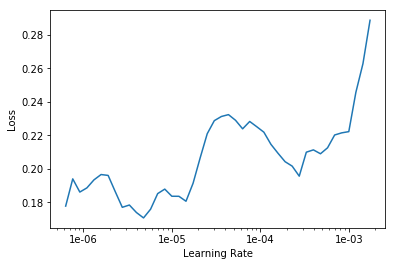

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(1,1e-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.169121,6.222925,0.035599,08:18


In [31]:
learn.save('stage-2-512')

In [32]:
preds,targ = learn.TTA(ds_type=DatasetType.Test)
labels = np.argmax(preds, 1)
test_predictions_direct = [data.classes[int(x)] for x in labels]

In [33]:
sub_df=pd.read_csv(path/'test.csv')
sub_df=sub_df.drop(columns=['image_id'])
sub_df['image_id']=data.test_ds.items
sub_df=sub_df.drop(columns=['category'])
sub_df['category']=test_predictions_direct
sub_df['image_id']=sub_df.image_id.map(lambda x: x.name.replace('.jpg',''))

In [34]:
sub_df=sub_df.sort_values(['image_id'])
sub_df.head()

,image_id,category
941,18540,9
491,18541,40
1848,18542,97
693,18543,72
480,18544,51


In [35]:
sub_df.to_csv('submission.csv', index=False)

In [36]:
from IPython.display import HTML
import base64
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [37]:
create_download_link(sub_df)